In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import scipy
import matplotlib.pyplot as plt

import sys, os

In [2]:
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
from lib.cgamma import c_gamma_prob, c_gamma_sf, c_multi_gamma_prob, c_multi_gamma_sf
from lib.plotting import adjust_plot_1d
from lib.network import get_network_eval_fn
from lib.geo import get_xyz_from_zenith_azimuth
from lib.trafos import transform_network_outputs, transform_network_inputs

In [3]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')
c_multi_gamma_prob_v1d_x = jax.vmap(c_multi_gamma_prob, (0, None, None, None, None, None), 0)
c_multi_gamma_sf_v1d_x = jax.vmap(c_multi_gamma_sf, (0, None, None, None, None), 0)

In [25]:
dist = 5
z = -500
rho = 0.0
zenith = 1.57
azimuth = 3.9264083

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_a, gamma_b = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

In [26]:
xvals = np.linspace(-20, 6000, 30000)
probs = c_multi_gamma_prob_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 3.0, 0.1)

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


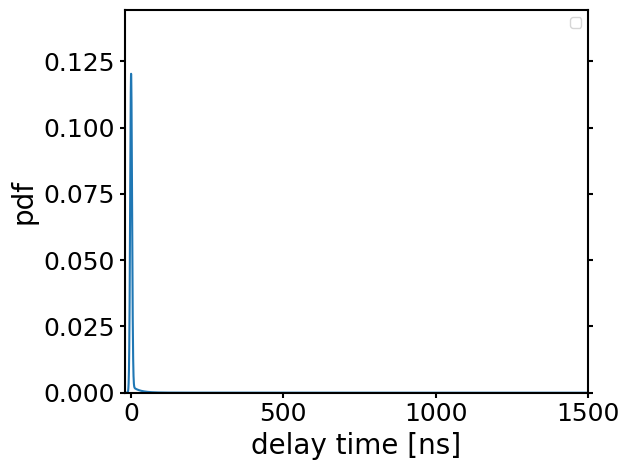

In [27]:
fig, ax = plt.subplots()
plt.plot(xvals, probs)
plot_args = {'xlim':[-20, 1500],
                     'ylim':[0.0, 1.2 * np.amax(probs)],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

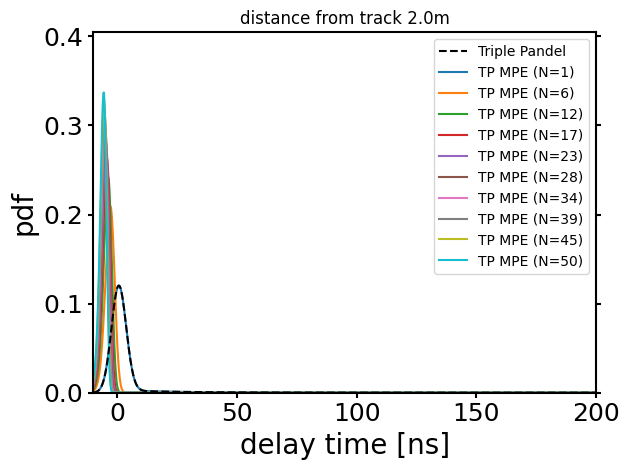

In [28]:
probs = c_multi_gamma_prob_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 3.0, 0.01)
sfs = c_multi_gamma_sf_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 3.0)

fig, ax = plt.subplots()
plt.plot(xvals, probs,linestyle='dashed', color='black', zorder=100, label='Triple Pandel')

y_max = np.amax(probs)
n_photons = jnp.array(np.linspace(1, 50, 10))
for n_p in n_photons:
    ys = n_p * probs * sfs**(n_p-1)
    plt.plot(xvals, ys, label=f'TP MPE (N={n_p:.0f})')
    y_max = np.amax([y_max, np.amax(ys)])
plot_args = {'xlim':[-10, 200],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m")
plt.tight_layout()
plt.show()

In [29]:
from scipy.integrate import quad

In [30]:
@jax.jit
def conv_mpe_pdf(x, mix_probs, gamma_a, gamma_b, sigma, n_photons):
    p = c_multi_gamma_prob(x, mix_probs, gamma_a, gamma_b, sigma)
    sf = c_multi_gamma_sf(x, mix_probs, gamma_a, gamma_b, sigma)
    return n_photons * p * jnp.power(sf, (n_photons-1))

def norm_mpe_pdf(dist, mix_probs, gamma_a, gamma_b, sigma, n_photons):
    f = lambda x: conv_mpe_pdf(x, mix_probs, gamma_a, gamma_b, sigma, n_photons)
    return  quad(f, -15, dist*30, epsabs=1.e-4)[0]

def mean_conv_mpe_pdf(dist, mix_probs, gamma_a, gamma_b, sigma, n_photons):
    f = lambda x: x * conv_mpe_pdf(x, mix_probs, gamma_a, gamma_b, sigma, n_photons)
    return quad(f, -15, dist*30, epsabs=1.e-4)[0]

def second_moment_conv_mpe_pdf(dist, mix_probs, gamma_a, gamma_b, sigma, n_photons):
    f = lambda x: x**2 * conv_mpe_pdf(x, mix_probs, gamma_a, gamma_b, sigma, n_photons)
    return quad(f, -15, dist*30, epsabs=1.e-4)[0]

In [33]:
print(dist)
n_photons = 6
norm = norm_mpe_pdf(dist, mix_probs, gamma_a, gamma_b, 3.0, n_photons)
print(norm)
mean = mean_conv_mpe_pdf(dist, mix_probs, gamma_a, gamma_b, 3.0, n_photons)
print(mean)
second_moment = second_moment_conv_mpe_pdf(dist, mix_probs, gamma_a, gamma_b, 3.0, n_photons)
err = np.sqrt(second_moment - mean**2)
print(err)

2
1.013118360701822
-3.03616963871462
1.9943061834002873


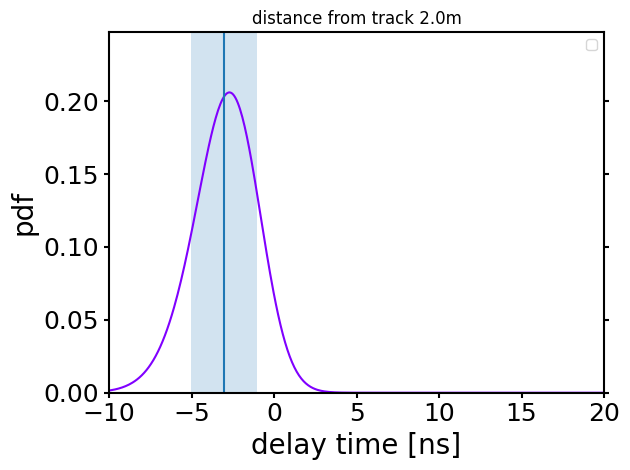

In [34]:
from matplotlib.pyplot import cm

fig, ax = plt.subplots()
xvals = np.linspace(-20, 50, 1000)

y_max = 0 
n_ps = [n_photons]
color = cm.rainbow(np.linspace(0, 1, len(n_ps)))

probs = c_multi_gamma_prob_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 3.0, 0.01)
sfs = c_multi_gamma_sf_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 3.0)

for i, n_p in enumerate(n_ps):
    ys = n_p * probs * sfs**(n_p-1)
    plt.plot(xvals, ys, color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])
plot_args = {'xlim':[-10, 20],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

ax.axvline(mean)
ax.axvspan(mean-err, mean+err, alpha=0.2)
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m")
plt.tight_layout()
plt.show()

In [23]:
def find_charge_max(distance, min_charge, max_charge):
    dist = distance
    z = -500
    rho = 0.0
    zenith = 1.57
    azimuth = 3.9264083
    
    x = jnp.array([dist, rho, z, zenith, azimuth])
    x_prime = transform_network_inputs(x)
    y = eval_network(x_prime)
    logits, gamma_a, gamma_b = transform_network_outputs(y)
    mix_probs = jax.nn.softmax(logits)

    mid_charge = (min_charge + max_charge)//2

    sigma = 3.0
    mean1 = mean_conv_mpe_pdf(dist, mix_probs, gamma_a, gamma_b, sigma, mid_charge)
    mean2 = mean_conv_mpe_pdf(dist, mix_probs, gamma_a, gamma_b, sigma, mid_charge-1)
    print(mid_charge, mean1, mean2)

    crit = -3
    if mean1 < crit:
        if mean2 > crit:
            return mid_charge
        else:
            charge = find_charge_max(distance, min_charge, mid_charge-1)
    else:
        charge = find_charge_max(distance, mid_charge+1, max_charge)

    return charge

In [36]:
find_charge_max(5.0, 2.0, .0)

101.0 -5.912468581351052 -5.90115660734147
51.0 -5.104518479738995 -5.080040940005986
26.0 -4.230357247407437 -4.176561160425514
13.0 -3.221787496712202 -3.09644640034795
7.0 -2.1924221135170177 -1.911412066361625
10.0 -2.802919381109561 -2.627858313619463
11.0 -2.957796139403168 -2.802919381109561
12.0 -3.09644640034795 -2.957796139403168


12.0

In [37]:
distances = np.linspace(1.0, 30.0, 30)
#uppers = np.exp(0.25*distances) + 4

cuts = [2.0]
for i, dist in enumerate(distances):
    print(f"distance: {dist}") 
    thresh = find_charge_max(dist, cuts[-1], 2000)
    print(thresh)
    cuts.append(thresh)

distance: 1.0
1001.0 -20.419929934734718 -20.408767507686306
501.0 -14.50747224518532 -14.494637911885285
251.0 -11.007976948744169 -10.992177990033964
126.0 -8.76729522765628 -8.745988353092073
63.0 -7.16356879692857 -7.1312314942348
32.0 -5.903158496124879 -5.848062038962348
16.0 -4.733208702370445 -4.625585221982218
8.0 -3.5561459383887835 -3.3198295077493496
4.0 -2.267869806590199 -1.6712851326420681
6.0 -3.0410004597954052 -2.7013267184635437
6.0
distance: 2.0
1003.0 -21.31915716034879 -21.307174409451747
504.0 -15.006991204433136 -14.993326822895819
254.0 -11.299361100695124 -11.282733093190714
129.0 -8.958575013904944 -8.936558765599063
67.0 -7.355122177485325 -7.323062015646061
36.0 -6.141232004989453 -6.090296864644624
20.0 -5.117573595241184 -5.0307066272515835
12.0 -4.253997830810867 -4.105670695348629
8.0 -3.5535670681414624 -3.316091700180528
6.0 -3.03616963871462 -2.6955142293149743
6.0
distance: 3.0
1003.0 -9.51276354937384 -9.511328384205664
504.0 -8.596880369396773 -8.

RecursionError: maximum recursion depth exceeded while calling a Python object

(1.0, 1000.0)

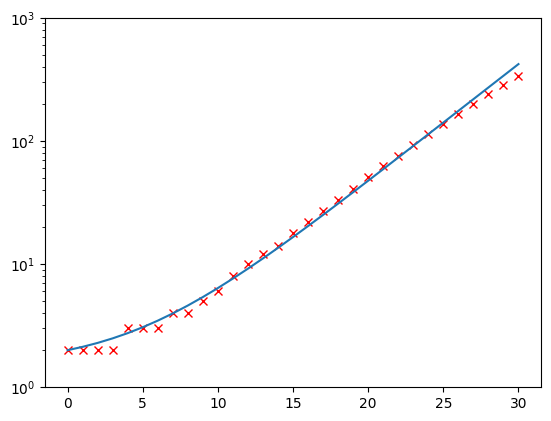

In [14]:
xvals = np.linspace(0.0, 30.0, 31)
plt.plot(xvals, cuts, "rx")
plt.plot(xvals, np.exp(0.21*xvals) / (1 + np.exp(-0.04*xvals))+1.5)
plt.yscale('log')
plt.ylim([1.0, 1.e3])

In [15]:
xvals = np.linspace(0.0, 30.0, 21)
yvals = np.exp(0.25*xvals) + 4

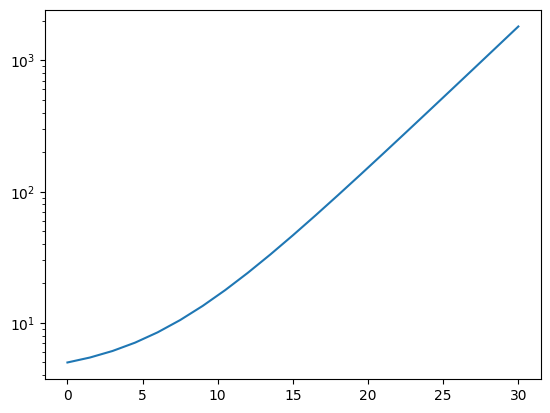

In [16]:
plt.plot(xvals, yvals)
plt.yscale('log')

In [17]:
print(yvals)

[   5.            5.45499141    6.11700002    7.08021685    8.48168907
   10.52081912   13.48773584   17.80457419   24.08553692   33.22428378
   46.521082     65.86780925   94.0171313   134.97415321  194.56626846
  281.27228452  407.42879349  590.98543094  858.05876253 1246.64816705
 1812.04241446]


In [18]:
def charge_clip_fn(x):
    return np.exp(0.21*x) / (1 + np.exp(-0.04*x))+1.5

In [19]:
print(charge_clip_fn(1.0))

2.129174165937001


In [38]:
print(len(cuts))

29


In [84]:
xvals = np.linspace(0.0, 28.0, 29)
yvals = 3.6*np.exp(0.23*xvals)

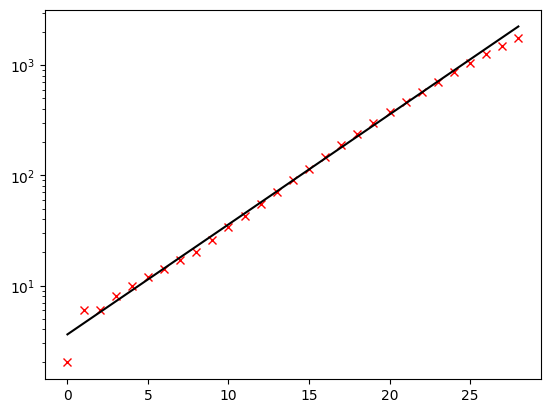

In [85]:
plt.plot(xvals, cuts, "rx")
plt.plot(xvals, yvals, "k-")
plt.yscale('log')

In [86]:
print(np.array(yvals))

[   3.6           4.53096004    5.70266635    7.17737592    9.0334454
   11.36949447   14.30964586   18.01012042   22.66753774   28.52936322
   35.90705684   45.19262209   56.87943461   71.58845697   90.10123265
  113.40141231  142.72701866  179.6362271   226.09015722  284.55707412
  358.14353631  450.75945836  567.32585876  714.03633147  898.68613388
 1131.08637703 1423.58532536 1791.72450463 2255.06447932]
